In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
import pickle

In [59]:
# merge the two
gdx = pd.read_csv('GDX.csv').drop('Adj Close', axis=1).interpolate(method='linear')
gdx['Date'] = pd.to_datetime(gdx['Date'])

sp500 = pd.read_csv('SPY.csv').drop(['Adj Close', 'Low', 'High', 'Open', 'Volume'], axis=1)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.columns = ['Date', 'SP500']

gold = pd.read_csv('gold.csv').iloc[::-1].reset_index().drop('index', axis=1)
gold = gold[gold['Close*'] != '-']
# convert date to datetime
gold['Date'] = pd.to_datetime(gold['Date'])

#merge data
merged = pd.merge(gdx, gold, on='Date')
data = pd.merge(merged, sp500, on='Date').drop('Date', axis=1).interpolate(method='linear')
data.columns = ['GDX open', 'GDX high', 'GDX low', 'GDX close', 'GDX volume', 'Gold close', 'SP500']
data['GDX volume'] = data['GDX volume'].astype(float)
data['Gold close'] = data['Gold close'].str.replace(',', '')
data['Gold close'] = data['Gold close'].astype(float)

# use only the last 1500 days
data = data[:3000]

data['GDX hist'] = np.nan
data['Diff'] = np.nan
data['Volatility'] = np.nan

ran = 200

for i in range(ran-1, len(data['GDX close'])):
    data['GDX hist'][i] = data['GDX close'][(i-ran):i].mean()
    data['Volatility'][i] = data['GDX close'][(i-ran):i].std()**2

data['Diff'] = (data['GDX close'] - data['GDX hist']) * data['Volatility']

data['y']= data['GDX close'].shift(-1)

data.dropna(inplace=True)

X = data.drop(['y'], axis=1)

X = MinMaxScaler().fit_transform(X)

Y = data['y']

validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

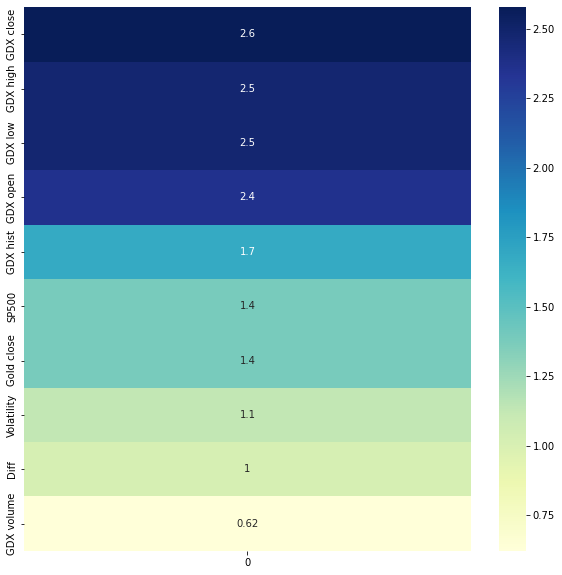

In [60]:
mi = pd.DataFrame()

for i in data.columns:
    if i != 'y':
        mi[i] = mutual_info_regression(pd.array(data[i]).reshape(-1, 1), data['y'])

mi = mi.transpose()
mi.sort_values(by=0, inplace=True)

#sort mi
mi = mi.sort_values(by=0, ascending=False)

# plot mi
plt.figure(figsize=(10,10))
sns.heatmap(mi, annot=True, cmap="YlGnBu")
plt.show()

In [7]:
X_train

array([[0.47719688, 0.47780242, 0.46007465, ..., 0.32105096, 0.52663467,
        0.62659566],
       [0.45068592, 0.45431   , 0.44888058, ..., 0.32576556, 0.52662538,
        0.63167789],
       [0.46310716, 0.47206803, 0.47164179, ..., 0.32663526, 0.5265557 ,
        0.65300696],
       ...,
       [0.02169077, 0.02349241, 0.02481343, ..., 0.55385182, 0.0075384 ,
        0.6038559 ],
       [0.0209492 , 0.02441731, 0.025     , ..., 0.57495312, 0.00689385,
        0.61298053],
       [0.03021876, 0.03200148, 0.03544776, ..., 0.57463268, 0.00622374,
        0.62430569]])

In [61]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mape', optimizer='adam')
    return model
model = create_model()
model_fit = model.fit(X_train, Y_train,validation_data=(X_test, Y_test), batch_size=128, epochs=400, shuffle=True)

Epoch 1/400
18/18 [==============================] - 0s 9ms/step - loss: 99.9095 - val_loss: 97.3305
Epoch 2/400
18/18 [==============================] - 0s 5ms/step - loss: 96.5053 - val_loss: 92.8049
Epoch 3/400
18/18 [==============================] - 0s 5ms/step - loss: 93.0533 - val_loss: 87.4605
Epoch 4/400
18/18 [==============================] - 0s 4ms/step - loss: 88.6646 - val_loss: 80.5600
Epoch 5/400
18/18 [==============================] - 0s 4ms/step - loss: 83.7573 - val_loss: 73.3546
Epoch 6/400
18/18 [==============================] - 0s 4ms/step - loss: 78.6197 - val_loss: 65.7599
Epoch 7/400
18/18 [==============================] - 0s 4ms/step - loss: 72.9166 - val_loss: 57.1767
Epoch 8/400
18/18 [==============================] - 0s 4ms/step - loss: 66.5350 - val_loss: 47.8178
Epoch 9/400
18/18 [==============================] - 0s 4ms/step - loss: 59.6418 - val_loss: 37.5425
Epoch 10/400
18/18 [==============================] - 0s 4ms/step - loss: 53.2974 - val_los

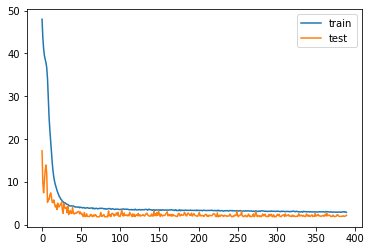

In [62]:
#plot the loss
skip = 10
pyplot.plot(model_fit.history['loss'][skip:], label='train')
pyplot.plot(model_fit.history['val_loss'][skip:], label='test')
pyplot.legend()
pyplot.show()
# save model
model.save('ann_model.h5')

In [63]:
x_total = np.append(X_train, X_test, axis=0)
y_total = np.append(Y_train, Y_test, axis=0)

linear_model = LinearRegression().fit(X_train, Y_train)
pred_linear = linear_model.predict(x_total)

print(np.mean(np.abs((linear_model.predict(x_total)-y_total)/y_total)))
print(np.mean(np.abs((linear_model.predict(X_test)-Y_test)/Y_test)))
print('---------------------')

xgb_model = XGBRegressor(colsample_bytree=.6, subsample=.4, max_depth=4, eta=.1, min_child_weight=10).fit(X_train, Y_train, verbose=False)
pred_xgb = xgb_model.predict(x_total)

print(np.mean(np.abs((xgb_model.predict(x_total)-y_total)/y_total)))
print(np.mean(np.abs((xgb_model.predict(X_test)-Y_test)/Y_test)))

0.020155188834355655
0.0190595449809
---------------------
0.01853124939046539
0.02149864666374484


In [64]:
# save xgb model
pickle.dump(xgb_model, open('xgb_model.sav', 'wb'))
#save linear model
pickle.dump(linear_model, open('linear_model.sav', 'wb'))

2798


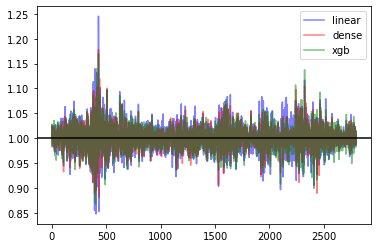

Dense: 0.026126490594047126
Linear: 0.029168739458237152
XGB: 0.024829952009313386


In [65]:
pred1 = model.predict(x_total)
pred_dense = list()

for i in range(len(pred1)):
    pred_dense.append(pred1[i][0])

y_total = y_total/np.roll(y_total, 1)
pred_dense = pred_dense/np.roll(pred_dense, 1)
pred_linear = pred_linear/np.roll(pred_linear, 1)
pred_xgb = pred_xgb/np.roll(pred_xgb, 1)


y_total = y_total[1:]
pred_dense = pred_dense[1:]
pred_linear = pred_linear[1:]
pred_xgb = pred_xgb[1:]

skip = 1
# moving average of prediction
pred_dense = np.convolve(pred_dense, np.ones((skip,))/skip, mode='valid')
# moving average of actual
y_total = np.convolve(y_total, np.ones((skip,))/skip, mode='valid')
# moving average of linear
pred_linear = np.convolve(pred_linear, np.ones((skip,))/skip, mode='valid')

print(len(pred_linear))

#plot

pyplot.plot(pred_linear, color='b',  label='linear', alpha=0.5)
pyplot.plot(pred_dense, color='r', label='dense', alpha=0.5)
pyplot.plot(pred_xgb, color='g', label='xgb', alpha=0.5)
#pyplot.plot(pred_linear, label='linear')
pyplot.axhline(y=1, color='black', linestyle='-')
pyplot.legend()
pyplot.show()

#print the mape
print('Dense:', np.mean(np.abs((pred_dense-y_total)/y_total)))
print('Linear:', np.mean(np.abs((pred_linear-y_total)/y_total)))
print('XGB:', np.mean(np.abs((pred_xgb-y_total)/y_total)))

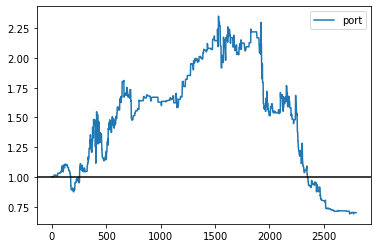

Rendimento -30.00%
R$0.70 final com R$1.0 de investimento inicial e R$0.0 de investimento diário
sharp = -2.381092691745999


In [66]:
# 1 if prediction is greater than 1
minimum = 1.025
maximum = .975

alavancagem = 1
c0 = 1
c1 = 0
opt = 0

predF = list()

if opt == 1:
    for i in range(0, len(pred_dense)):
        if pred_dense[i] and pred_linear[i] and pred_xgb[i] > minimum:
            predF.append(1)
        elif pred_dense[i] and pred_linear[i] and pred_xgb[i] < maximum:
            predF.append(-1)
        else:
            predF.append(0)
else:
    predF = (pred_dense+pred_linear+pred_xgb)/3
    for i in range(0, len(predF)):
        if predF[i] > minimum:
            predF[i] = 1
        elif predF[i] < maximum:
            predF[i] = -1
        else:
            predF[i] = 0

predF = predF*(y_total-1)

port = list()
port.append(predF[0]+c0)
for i in range(1, len(predF)):
    calc = port[i-1]+alavancagem*port[i-1]*(predF[i])+c1
    if calc > 0:
        port.append(calc)
    else:
        port.append(0)

#plot port
pyplot.plot(port, label='port')
pyplot.axhline(y=c0, color='black', linestyle='-')
pyplot.legend()
pyplot.show()

print('Rendimento {:.2f}%'.format((port[-1]*100/c0)-100))
print('R${:.2f} final com R${:.1f} de investimento inicial e R${:.1f} de investimento diário'.format(port[-1]/c0, c0, c1))
print('sharp =', (port[-1]-(1.08**(len(predF)/365)))/np.std(port))